Train data (x_train):  (50000, 32, 32, 3)
Train labels (y_train):  (50000, 1)
Test data (x_test):  (10000, 32, 32, 3)
Test labels (y_test):  (10000, 1)


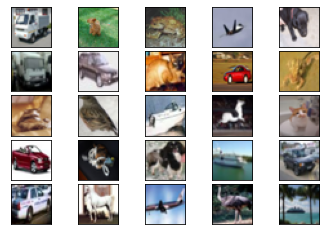

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys
import os

def load_batch(f_path, label_key='labels'):
  
    with open(f_path, 'rb') as f:
        if sys.version_info < (3,):
            d = pickle.load(f)
        else:
            d = pickle.load(f, encoding='bytes')
            # decode utf8
            d_decoded = {}
            for k, v in d.items():
                d_decoded[k.decode('utf8')] = v
            d = d_decoded
    data = d['data']
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels


def load_data(path, negatives=False):
    """Loads CIFAR10 dataset.
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """

    num_train_samples = 50000

    x_train_local = np.empty((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train_local = np.empty((num_train_samples,), dtype='uint8')

    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        (x_train_local[(i - 1) * 10000: i * 10000, :, :, :],
         y_train_local[(i - 1) * 10000: i * 10000]) = load_batch(fpath)

    fpath = os.path.join(path, 'test_batch')
    x_test_local, y_test_local = load_batch(fpath)

    y_train_local = np.reshape(y_train_local, (len(y_train_local), 1))
    y_test_local = np.reshape(y_test_local, (len(y_test_local), 1))

    if negatives:
        x_train_local = x_train_local.transpose(0, 2, 3, 1).astype(np.float32)
        x_test_local = x_test_local.transpose(0, 2, 3, 1).astype(np.float32)
    else:
        x_train_local = np.rollaxis(x_train_local, 1, 4)
        x_test_local = np.rollaxis(x_test_local, 1, 4)

    return (x_train_local, y_train_local), (x_test_local, y_test_local)


if __name__ == "__main__":
    """show it works"""

    cifar_10_dir = 'cifar-10-batches-py'

    (x_train, y_train), (x_test, y_test) = load_data(cifar_10_dir)

    print("Train data (x_train): ", x_train.shape)
    print("Train labels (y_train): ", y_train.shape)
    print("Test data (x_test): ", x_test.shape)
    print("Test labels (y_test): ", y_test.shape)

    # Don't forget that the label_names and filesnames are in binary and need conversion if used.

    # display some random training images in a 25x25 grid
    num_plot = 5
    fig, ax = plt.subplots(num_plot, num_plot)
    for m in range(num_plot):
        for n in range(num_plot):
            idx = np.random.randint(0, x_train.shape[0])
            ax[m, n].imshow(x_train[idx])
            ax[m, n].get_xaxis().set_visible(False)
            ax[m, n].get_yaxis().set_visible(False)
    fig.subplots_adjust(hspace=0.1)
    fig.subplots_adjust(wspace=0)
    plt.show()

In [2]:
import keras
# from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import optimizers
from keras import regularizers
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import pickle
import sys
import os

Using TensorFlow backend.


In [3]:
batch_size = 1024
num_classes = 10
epochs = 10
num_predictions = 20


In [4]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## Classification  accuracy Curves and Cross-entropyerror  curves

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 614s 12ms/step - loss: 2.2066 - accuracy: 0.2526 - val_loss: 1.8050 - val_accuracy: 0.3761
Epoch 2/10
50000/50000 [==============================] - 624s 12ms/step - loss: 1.6927 - accuracy: 0.4162 - val_loss: 1.5458 - val_accuracy: 0.4657
Epoch 3/10
50000/50000 [==============================] - 591s 12ms/step - loss: 1.5215 - accuracy: 0.4784 - val_loss: 1.4391 - val_accuracy: 0.5069
Epoch 4/10
50000/50000 [==============================] - 565s 11ms/step - loss: 1.4036 - accuracy: 0.5246 - val_loss: 1.3480 - val_accuracy: 0.5530
Epoch 5/10
50000/50000 [==============================] - 560s 11ms/step - loss: 1.3274 - accuracy: 0.5548 - val_loss: 1.2458 - val_accuracy: 0.5843
Epoch 6/10
50000/50000 [==============================] - 554s 11ms/step - loss: 1.2515 - accuracy: 0.5910 - val_loss: 1.1662 - val_accuracy: 0.6164
Epoch 7/10
50000/50000 [==============================] 

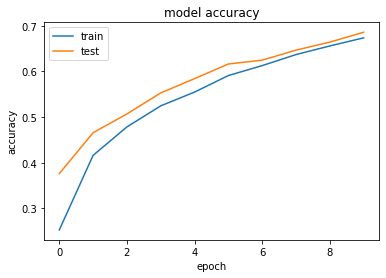

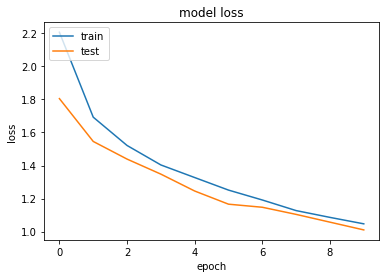

In [5]:
model = Sequential()
model.add(Conv2D(64, (5, 5), padding='same',
                 input_shape=x_train.shape[1:],kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))

model.add(Conv2D(64, (5, 5) ,kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(384, (5, 5), padding='same',kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))

model.add(Conv2D(192, (5, 5),kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(num_classes))
model.add(Activation('softmax'))



# initiate Adam optimizer
opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

# Let's train the model using Adam
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=False)


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



In [6]:
from matplotlib import pyplot
# load the model
model = Sequential()
model.add(Conv2D(64, (5, 5), padding='same',
                 input_shape=x_train.shape[1:],kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))

model.add(Conv2D(64, (5, 5) ,kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(384, (5, 5), padding='same',kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))

model.add(Conv2D(192, (5, 5),kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate Adam optimizer
opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

# Let's train the model using Adam
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
# summarize filter shapes
for layer in model.layers:
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# get filter weights
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

conv2d_5 (5, 5, 3, 64)
conv2d_6 (5, 5, 64, 64)
conv2d_7 (5, 5, 64, 384)
conv2d_8 (5, 5, 384, 192)


##  first  5  filters in the1st and 2nd convolutional  layers

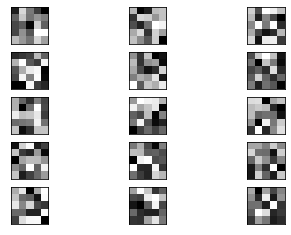

In [7]:

from matplotlib import pyplot
# load the model
model = Sequential()
model.add(Conv2D(64, (5, 5), padding='same',
                 input_shape=x_train.shape[1:],kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))

model.add(Conv2D(64, (5, 5) ,kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(384, (5, 5), padding='same',kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))

model.add(Conv2D(192, (5, 5),kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate Adam optimizer
opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

# Let's train the model using Adam
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# retrieve weights from the first hidden layer
filters, biases = model.layers[0].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 5, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = pyplot.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

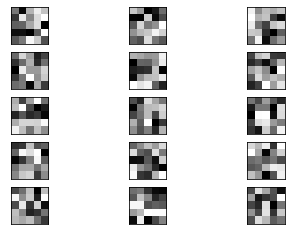

In [8]:
# retrieve weights from the second hidden layer
filters, biases = model.layers[2].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 5, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = pyplot.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

## Part 2 with original  dataset  into grayscale 

In [9]:
def grayscale(data,dtype='float32'):
    r,g,b=np.asarray(.3,dtype=dtype),np.asarray(.59,dtype=dtype),np.asarray(.11,dtype=dtype)
    rst=r*data[:,:,:,0]+g*data[:,:,:,1]+b*data[:,:,:,2]
    rst=np.expand_dims(rst,axis=3)
    return rst

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys
import os

"""
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 
training images and 10000 test images.
The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains 
exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random 
order, but some training batches may contain more images from one class than another. Between them, the training 
batches contain exactly 5000 images from each class.
"""


def load_batch(f_path, label_key='labels'):
    """Internal utility for parsing CIFAR data.
    # Arguments
        fpath: path the file to parse.
        label_key: key for label data in the retrieve
            dictionary.
    # Returns
        A tuple `(data, labels)`.
    """
    with open(f_path, 'rb') as f:
        if sys.version_info < (3,):
            d = pickle.load(f)
        else:
            d = pickle.load(f, encoding='bytes')
            # decode utf8
            d_decoded = {}
            for k, v in d.items():
                d_decoded[k.decode('utf8')] = v
            d = d_decoded
    data = d['data']
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels


def load_data(path, negatives=False):
    """Loads CIFAR10 dataset.
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """

    num_train_samples = 50000

    x_train_local = np.empty((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train_local = np.empty((num_train_samples,), dtype='uint8')

    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        (x_train_local[(i - 1) * 10000: i * 10000, :, :, :],
         y_train_local[(i - 1) * 10000: i * 10000]) = load_batch(fpath)

    fpath = os.path.join(path, 'test_batch')
    x_test_local, y_test_local = load_batch(fpath)

    y_train_local = np.reshape(y_train_local, (len(y_train_local), 1))
    y_test_local = np.reshape(y_test_local, (len(y_test_local), 1))

    if negatives:
        x_train_local = x_train_local.transpose(0, 2, 3, 1).astype(np.float32)
        x_test_local = x_test_local.transpose(0, 2, 3, 1).astype(np.float32)
    else:
        x_train_local = np.rollaxis(x_train_local, 1, 4)
        x_test_local = np.rollaxis(x_test_local, 1, 4)

    return (x_train_local, y_train_local), (x_test_local, y_test_local)


if __name__ == "__main__":
    """show it works"""

    cifar_10_dir = 'cifar-10-batches-py'

    (x_train, y_train), (x_test, y_test) = load_data(cifar_10_dir)
    x_train_gray=grayscale(x_train)
    x_test_gray=grayscale(x_test)

    

    print("Train data (x_train_gray): ", x_train_gray.shape)
    print("Train labels (y_train): ", y_train.shape)
    print("Test data (x_test_gray): ", x_test_gray.shape)
    print("Test labels (y_test): ", y_test.shape)

  

Train data (x_train_gray):  (50000, 32, 32, 1)
Train labels (y_train):  (50000, 1)
Test data (x_test_gray):  (10000, 32, 32, 1)
Test labels (y_test):  (10000, 1)


In [11]:
batch_size = 1024
num_classes = 10
epochs = 10
num_predictions = 20


In [12]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 641s 13ms/step - loss: 2.2030 - accuracy: 0.2303 - val_loss: 1.8656 - val_accuracy: 0.3354
Epoch 2/10
50000/50000 [==============================] - 675s 13ms/step - loss: 1.7867 - accuracy: 0.3717 - val_loss: 1.7191 - val_accuracy: 0.4087
Epoch 3/10
50000/50000 [==============================] - 766s 15ms/step - loss: 1.6399 - accuracy: 0.4397 - val_loss: 1.5687 - val_accuracy: 0.4715
Epoch 4/10
50000/50000 [==============================] - 603s 12ms/step - loss: 1.5371 - accuracy: 0.4870 - val_loss: 1.4557 - val_accuracy: 0.5107
Epoch 5/10
50000/50000 [==============================] - 588s 12ms/step - loss: 1.4437 - accuracy: 0.5238 - val_loss: 1.4186 - val_accuracy: 0.5420
Epoch 6/10
50000/50000 [==============================] - 578s 12ms/step - loss: 1.3766 - accuracy: 0.5548 - val_loss: 1.3339 - val_accuracy: 0.5692
Epoch 7/10
50000/50000 [==============================] 

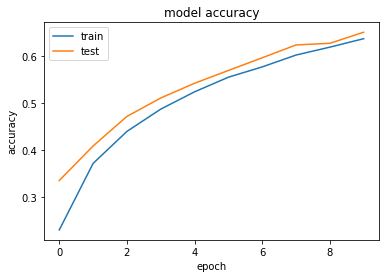

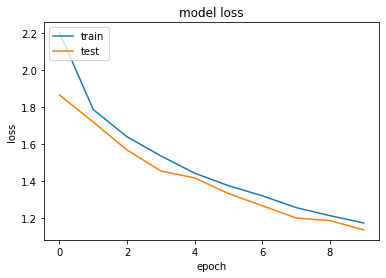

In [13]:
model = Sequential()
model.add(Conv2D(64, (5, 5), padding='same',
                 input_shape=x_train_gray.shape[1:],kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))

model.add(Conv2D(64, (5, 5) ,kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(384, (5, 5), padding='same',kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))

model.add(Conv2D(192, (5, 5),kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(num_classes))
model.add(Activation('softmax'))



# initiate Adam optimizer
opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

# Let's train the model using Adam
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train_gray = x_train_gray.astype('float32')
x_test_gray = x_test_gray.astype('float32')
x_train_gray /= 255
x_test_gray /= 255


history = model.fit(x_train_gray, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test_gray, y_test))


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



## first  5  filters in the1st and 2nd convolutional  layers

In [14]:
model = Sequential()
model.add(Conv2D(64, (5, 5), padding='same',
                 input_shape=x_train_gray.shape[1:],kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))

model.add(Conv2D(64, (5, 5) ,kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(384, (5, 5), padding='same',kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))

model.add(Conv2D(192, (5, 5),kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(num_classes))
model.add(Activation('softmax'))



# initiate Adam optimizer
opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

# Let's train the model using Adam
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# summarize filter shapes
for layer in model.layers:
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# get filter weights
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

conv2d_17 (5, 5, 1, 64)
conv2d_18 (5, 5, 64, 64)
conv2d_19 (5, 5, 64, 384)
conv2d_20 (5, 5, 384, 192)


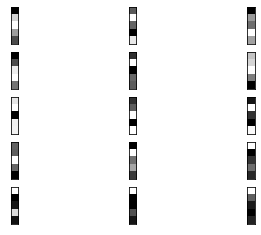

In [15]:
# retrieve weights from the first hidden layer
filters, biases = model.layers[0].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 5, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = pyplot.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(f[:, j], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

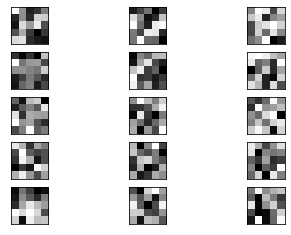

In [16]:
# retrieve weights from the second hidden layer
filters, biases = model.layers[2].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 5, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = pyplot.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(f[:,:, j], cmap='gray')
		ix += 1
# show the figure
pyplot.show()